In [1]:
#%% Análisis de las primeras mediciones del espectro del rubidio,
#Sin descomponer en polarización circ izquierda ni nada.

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.optimize import curve_fit
import os
from scipy.signal import savgol_filter
from scipy.signal import find_peaks


In [2]:
def cargar_datos(n, i, ruta):
    #n número de datos tomados +1
    # i número de medición -1 (empezando a contar desde 1)

    columnas = [f'{j}' for j in range(1, n)]

    # Rutas a archivos
    señales_Ch1 = os.path.join(ruta, 'Mediciones_CH1.csv')
    señales_Ch2 = os.path.join(ruta, 'Mediciones_CH2.csv')
    tiempos_Ch1 = os.path.join(ruta, 'Tiempos_CH1.csv')
    tiempos_Ch2 = os.path.join(ruta, 'Tiempos_CH2.csv')
    unidades_escalas = os.path.join(ruta, 'Unidades y escala.csv')

    # Lectura de archivos
    data_señales_Ch1 = pd.read_csv(señales_Ch1, skiprows=3, delimiter=',', header=None, names=columnas)
    data_señales_Ch2 = pd.read_csv(señales_Ch2, skiprows=3, delimiter=',', header=None, names=columnas)
    data_tiempos_Ch1 = pd.read_csv(tiempos_Ch1, skiprows=3, delimiter=',', header=None, names=columnas)
    data_tiempos_Ch2 = pd.read_csv(tiempos_Ch2, skiprows=3, delimiter=',', header=None, names=columnas)
    data_unidades_escalas = pd.read_csv(unidades_escalas, delimiter=',', header=None, names=columnas)

    # Selección de columna
    col_name = str(i + 1)

    # Extraer variables

    globals()['tiempos1'] = data_tiempos_Ch1[col_name].values
    globals()['voltajes1'] = data_señales_Ch1[col_name].values

    globals()['tiempos2'] = data_tiempos_Ch2[col_name].values
    globals()['voltajes2'] = data_señales_Ch2[col_name].values

    escala_Ch1 = float(data_unidades_escalas[col_name].iloc[4])
    escala_Ch2 = float(data_unidades_escalas[col_name].iloc[8])

    globals()['error_Ch1'] = escala_Ch1 * 10 / 256
    globals()['error_Ch2'] = escala_Ch2 * 10 / 256



def lineal(x, m, b):
  y =  m * x + b
  return y



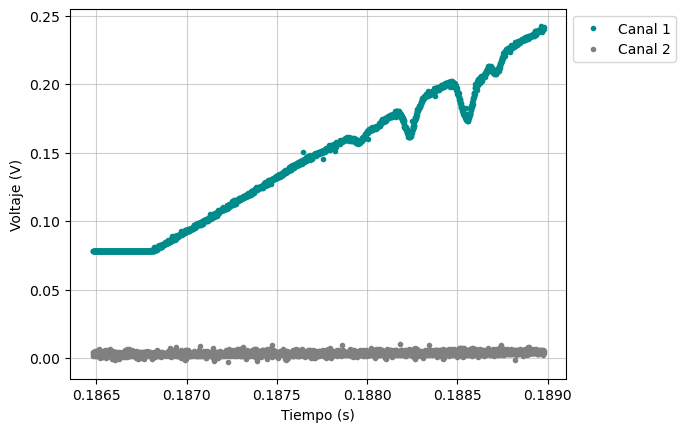

In [3]:
cargar_datos(n=2, i=0, ruta='/Users/Mauri/Desktop/Labo 5/Espectroscopía láser/Med1')

# Graficamos ambos canales.
plt.plot(tiempos1, voltajes1,'.', color = 'darkcyan', label= 'Canal 1')
plt.plot(tiempos2, voltajes2, '.', color ='gray', label= 'Canal 2')
plt.xlabel('Tiempo (s)')
plt.ylabel('Voltaje (V)')
plt.legend(loc="upper left", bbox_to_anchor=(1, 1))
#plt.xlim(-0.0015,-00.0016)
plt.grid(alpha = 0.6)
plt.show()

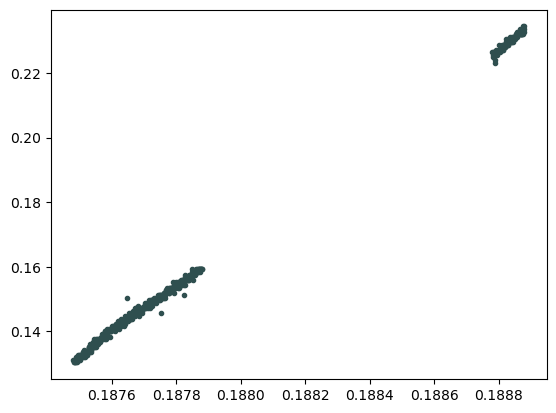

   Los parametros óptimos son  Los errores de los parámetros son
0                   72.728123                           0.074081
1                  -13.503824                           0.013921


In [23]:

#Ahora hay que restarle los puntos de una recta con pendiente igual a la obtenida en la curva pitencia vs corriente
#(asumiendo que más voltaje = más potencia)

# Como las mediciones de potencia vs corriente salieron mal, ajusto por la recta en la región de antes
# de las líneas espectrales para restarle esa lineal a las mediciones

A = 1000
B = 1400

C = 2300
D = 2400

plt.plot(tiempos2[A:B], voltajes1[A:B], ".", color = 'darkslategray')
plt.plot(tiempos2[C:D], voltajes1[C:D], ".", color = 'darkslategray')

plt.show()

#para que esté bien plana la señal, uso un intervalo antes del espectro, y después del espectro,
#y realizo el ajuste lineal con estos dos intervalos
voltajes_intervalos = np.concatenate([voltajes1[A:B], voltajes1[C:D]])
tiempos_intervalos = np.concatenate([tiempos2[A:B], tiempos2[C:D]])

#Cuando se vea la recta, hago el ajuste:

param_iniciales = [0.01, 0]
popt_0, pcov_0 = curve_fit(lineal, tiempos_intervalos,voltajes_intervalos, p0=param_iniciales, sigma = error_Ch1, absolute_sigma=True)
incertidumbre_0 = np.sqrt(np.diag(pcov_0))

tabla = pd.DataFrame({
        'Los parametros óptimos son': popt_0,
        'Los errores de los parámetros son': incertidumbre_0,
        })

print(tabla)



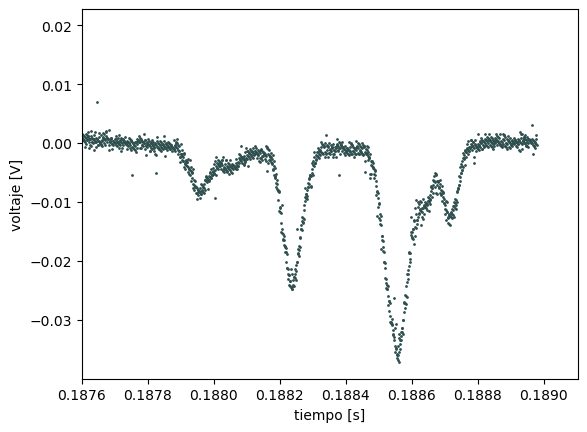

In [24]:
#Grafico el espectro sin la componente que hace crecer la intensidad del láser por
#el solo hecho de que tiene más corriente

x_fit_n =  np.linspace(np.min(tiempos1), np.max(tiempos1), len(tiempos1), endpoint = True)

plt.plot(tiempos1, voltajes1 - lineal(x_fit_n, *popt_0), ".", markersize=2, color = 'darkslategray')

plt.xlabel('tiempo [s]')
plt.ylabel('voltaje [V]')

plt.xlim(0.1876)
plt.show()

t_espectro = tiempos1[B:C] #así ya está recortado
espectro = (voltajes1 - lineal(x_fit_n, *popt_0))[B:C]


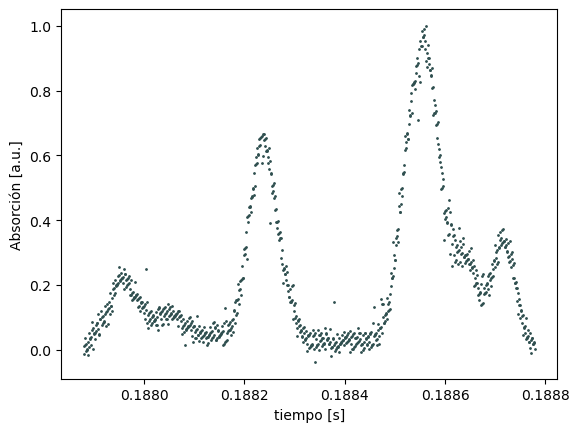

In [25]:
#inertimos, para graficar la Absorción en función del tiempo
#Y normalizamos para que el pico de mayor amplitud valga 1

espectro_inv = espectro * (-1)
espectro_norm = espectro_inv / np.max(espectro_inv)


plt.plot(t_espectro, espectro_norm, ".", markersize=2, color = 'darkslategray')

plt.xlabel('tiempo [s]')
plt.ylabel('Absorción [a.u.]')

#plt.xlim(0.1876)
#plt.ylim(0)
plt.show()



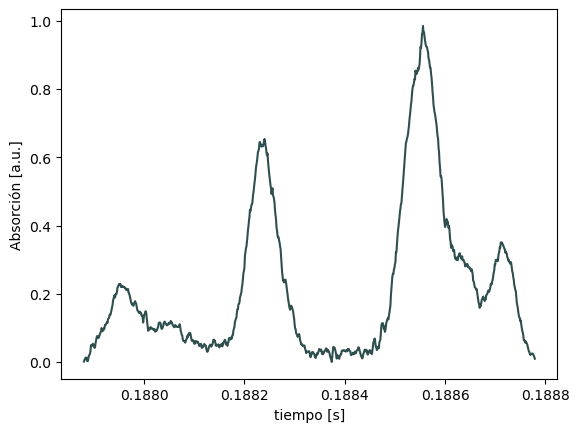

In [26]:
#pruebo de interpolar para suavizar la señal:

#(filtro 'Savitzky-Golay')
from scipy.signal import savgol_filter
señal_suavizada = savgol_filter(espectro_norm, window_length=11, polyorder=2)

plt.plot(t_espectro, señal_suavizada, "-", markersize=2, color = 'darkslategray')

plt.xlabel('tiempo [s]')
plt.ylabel('Absorción [a.u.]')

plt.show()

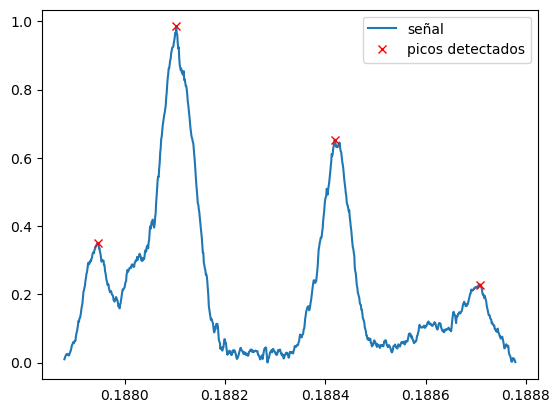

Primer pico: 0.187947
Último pico: 0.188708


In [29]:
# Asignar frecuencias relativas

# por alguna razón está espejado el espectro, lo pongo bien

espectro_suave = señal_suavizada[::-1]


#encuentro el primer y último pico

peaks, props = find_peaks(
    espectro_suave,
    height=0.2,        # altura mínima del pico
    distance=100,       # distancia mínima en puntos entre picos
    prominence=0.05    # "prominencia" mínima (cuán destacado es el pico)
)

plt.plot(t_espectro, espectro_suave , label="señal")
plt.plot(t_espectro[peaks], espectro_suave[peaks], "rx", label="picos detectados")
plt.legend()
plt.show()


# para reescalear y pasar de tiempos a frecuencias, tomo el primer pico y le
# asignamos la frecuencia de la primera línea del Rb, y lo mismo para el último
# y reescaleamos según eso todo el resto de tiempos

# obtener primer y último pico real
x_first, x_last = t_espectro[peaks][0], t_espectro[peaks][-1]
print("Primer pico:", x_first)
print("Último pico:", x_last)

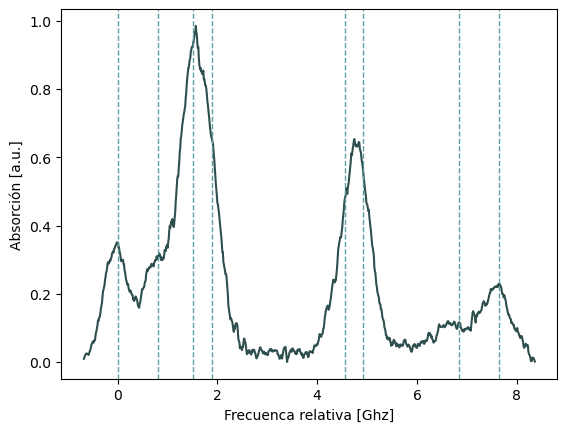

In [36]:
# primeras y últimas frecuencias relativas y absolutas (Rb87 y Rb85)

freqs = [0, 0.814, 1.518, 1.883, 4.556, 4.916, 6.835, 7.649]

frecuencias_abs = [377.104391, 377.112040] #THz
frecuencias_rel = [0, 7.649] #Ghz

# reescaleo los tiempos a las frecuencias 
# Fórmula de reescalado
freq_relativas = (t_espectro - x_first) / (x_last - x_first) * (7.649 - 0) + 0 # le pongo el cero por si lo quiero cambiar después
freq_absolutas = (t_espectro - x_first) / (x_last - x_first) * (frecuencias_abs[1] - frecuencias_abs[0]) + frecuencias_abs[0]


plt.plot(freq_relativas, espectro_suave, "-", markersize=2, color = 'darkslategray')

plt.xlabel('Frecuenca relativa [Ghz]')
plt.ylabel('Absorción [a.u.]')

for i in range(len(freqs)):
    plt.axvline(x=freqs[i] , color='cadetblue', linestyle='--', linewidth=1)

plt.show()

#No es suuper exacto pero no importa, el gráfico es estimativo, y esto lo bueno es que se puede automatizar


# Súper-compacto

Función para hacer todo esto

devuelve: array de la señal normalizada y suave, eje x con las frecuencas relativas y eje x con las frecuencias absolutas,  
y los gráficos para ir ajustando los valores de `A,B,C,D` y los de find.peaks (`height`, `distance` y `performance`)

`espectro_suave_a`   
`f_rel_a`  
`f_abs_a`    

`n` cantidad de mediciones en el csv + 1  
`i` índice de la medicion a analizar (empezando desde 0)  
`a` sufijo para diferenciar mediciones  
`ruta` ruta de la carpeta con los 5 csv  
`A,B,C,D` límites para ajustar la lineal (para 'aplanar' la señal)  
`h` altura a partir de la cual calcula los máximos (picos)  
`dis` distancia mínima en puntos entre picos  
`pro` "prominencia" mínima (cuán destacado es el pico)  
`graficar` True muestra para ir variando los parámetros, False no los muestra  
`norm` True, normaliza la señal por su valor más alto, False no lo hace -> esto lo puse para, al variar la temperatura, ver si aumenta la absorción en cada pico.

La función asume la señal del espectro en el canal 1

In [3]:

def cargar_datos_2(n, i, ruta, a):
    
    #n número de datos tomados +1
    # i número de medición -1 (empezando a contar desde 1)
    # sufijo para cada medición distinta

    columnas = [f'{j}' for j in range(1, n)]

    # Rutas a archivos
    señales_Ch1 = os.path.join(ruta, 'Mediciones_CH1.csv')
    señales_Ch2 = os.path.join(ruta, 'Mediciones_CH2.csv')
    tiempos_Ch1 = os.path.join(ruta, 'Tiempos_CH1.csv')
    tiempos_Ch2 = os.path.join(ruta, 'Tiempos_CH2.csv')
    unidades_escalas = os.path.join(ruta, 'Unidades y escala.csv')

    # Lectura de archivos
    data_señales_Ch1 = pd.read_csv(señales_Ch1, skiprows=3, delimiter=',', header=None, names=columnas)
    data_señales_Ch2 = pd.read_csv(señales_Ch2, skiprows=3, delimiter=',', header=None, names=columnas)
    data_tiempos_Ch1 = pd.read_csv(tiempos_Ch1, skiprows=3, delimiter=',', header=None, names=columnas)
    data_tiempos_Ch2 = pd.read_csv(tiempos_Ch2, skiprows=3, delimiter=',', header=None, names=columnas)
    data_unidades_escalas = pd.read_csv(unidades_escalas, delimiter=',', header=None, names=columnas)

    # Selección de columna
    col_name = str(i + 1)

    # Variables con sufijo personalizado
    globals()[f'tiempos1_{a}'] = data_tiempos_Ch1[col_name].values
    globals()[f'voltajes1_{a}'] = data_señales_Ch1[col_name].values

    globals()[f'tiempos2_{a}'] = data_tiempos_Ch2[col_name].values
    globals()[f'voltajes2_{a}'] = data_señales_Ch2[col_name].values

    escala_Ch1 = float(data_unidades_escalas[col_name].iloc[4])
    escala_Ch2 = float(data_unidades_escalas[col_name].iloc[8])

    globals()[f'error_Ch1_{a}'] = escala_Ch1 * 10 / 256
    globals()[f'error_Ch2_{a}'] = escala_Ch2 * 10 / 256


def lineal(x, m, b):
  y =  m * x + b
  return y


def graficar_6_subplots(x1, y1, x2, y2, x3, y3, x4, y4, x5, y5, x6, y6, peaks): #tengo que agregar peaks para poder usarlo dentro de la función
    fig, axs = plt.subplots(3, 2, figsize=(10, 9))  # 3 filas, 2 columnas

    # Gráfico 1
    axs[0, 0].plot(x1, y1, '.', color='darkcyan', label='Canal 1')
    axs[0, 0].set_title("señal osciloscopio")
    axs[0, 0].set_xlabel("tiempo [s]")
    axs[0, 0].set_ylabel("v")

    # Gráfico 2
    axs[0, 1].plot(x2, y2, ".", color='darkslategray')
    axs[0, 1].set_title("recorte lineal")
    axs[0, 1].set_xlabel("tiempo [s]")
    axs[0, 1].set_ylabel("v")

    # Gráfico 3
    axs[1, 0].plot(x3, y3, ".", markersize=2, color='darkslategray')
    axs[1, 0].set_title("aplanado")
    axs[1, 0].set_xlabel("tiempo [s]")
    axs[1, 0].set_ylabel("Absorción [a.u.]")

    # Gráfico 4
    axs[1, 1].plot(x4, y4, ".", markersize=2, color='darkslategray')
    axs[1, 1].set_title("normalizado e invertido")
    axs[1, 1].set_xlabel("tiempo [s]")
    axs[1, 1].set_ylabel("Absorción [a.u.]")

    # Gráfico 5
    axs[2, 0].plot(x5, y5, label="señal")
    axs[2, 0].plot(x5[peaks], y5[peaks], "rx",label="picos detectados")

    axs[2, 0].set_title("picos")
    axs[2, 0].set_xlabel("tiempo [s]")
    axs[2, 0].set_ylabel("Absorción [a.u.]")
    axs[2, 0].legend()  # <-- Mostrar leyenda sólo en el quinto gráfico

    # Gráfico 6
    axs[2, 1].plot(x6, y6, ".", markersize=2, color='teal')
    axs[2, 1].set_title("reescalado")
    axs[2, 1].set_xlabel("Frecuencia relativa (Ghz)")
    axs[2, 1].set_ylabel("Absorción [a.u.]")

    plt.tight_layout()
    plt.show()



In [41]:

def análisis_compacto(n, i, a, ruta, A, B, C, D, h, dis, pro, graficar=True, norm=True):

        cargar_datos_2(n = n, i = i, ruta=ruta, a = 'a')

        #uso los dos extremos de la parte lineal para ajustar

        voltajes_intervalos_a = np.concatenate([voltajes1_a[A:B], voltajes1_a[C:D]])
        tiempos_intervalos_a = np.concatenate([tiempos1_a[A:B], tiempos1_a[C:D]])

        #Cuando se vea la recta, hago el ajuste:

        x_fit_a =  np.linspace(np.min(tiempos2_a), np.max(tiempos2_a), len(tiempos2_a), endpoint = True)

        param_iniciales = [0.01, 0]
        popt_0, pcov_0 = curve_fit(lineal, tiempos_intervalos_a,voltajes_intervalos_a, p0=param_iniciales, sigma = error_Ch1_a, absolute_sigma=True)
        incertidumbre_0 = np.sqrt(np.diag(pcov_0))

        tabla = pd.DataFrame({
                'Los parametros óptimos son': popt_0,
                'Los errores de los parámetros son': incertidumbre_0,
                })
        if graficar:#así oculto estas salidas
                print(tabla)


        t_espectro_a = tiempos1_a[B:C] #así ya está recortado
        espectro_a = (voltajes1_a - lineal(x_fit_a, *popt_0))[B:C] 

        #inertimos, para graficar la absorción en función del tiempo
        #Y normalizamos para que el pico de mayor amplitud valga 1
        #Además, hacemos que la señal sea toda positiva (así al comparar están todas en la misma escala vertical)
        espectro_a_inv = espectro_a * (-1)
        espectro_a_pos = espectro_a_inv - np.min(espectro_a_inv) # con el - me aseguro de si ya es toda positiva, que se baje el minimo al cero
        
        #normalizamos
        espectro_a_norm = espectro_a_pos / np.max(espectro_a_pos)

        #filtrado
        señal_suavizada_a = savgol_filter(espectro_a_norm, window_length=11, polyorder=2)
  
        #damos vuelta el espectro
        espectro_suave_a = señal_suavizada_a[::-1]


        #encuentro el primer y último pico

        peaks, props = find_peaks(
        espectro_suave_a,
        height= h,        # altura mínima del pico
        distance= dis,      # distancia mínima en puntos entre picos
        prominence= pro    # "prominencia" mínima (cuán destacado es el pico)
        )

        # obtener primer y último pico real
        x_first, x_last = t_espectro_a[peaks][0], t_espectro_a[peaks][-1]
        
        if graficar:#así oculto estas salidas
                print("Primer pico:", x_first)
                print("Último pico:", x_last)


        # reescaleo los tiempos a las frecuencias 
        # Fórmula de reescalado
        frecuencias_abs = [377.104391, 377.112040] #THz
        frecuencias_rel = [0, 7.649] #Ghz

        freq_relativas = (t_espectro_a - x_first) / (x_last - x_first) * (7.649 - 0) + 0 # le pongo el cero por si lo quiero cambiar después
        freq_absolutas = (t_espectro_a - x_first) / (x_last - x_first) * (frecuencias_abs[1] - frecuencias_abs[0]) + frecuencias_abs[0]


        if norm:
                espectro_suave_a = espectro_suave_a
        else:
                espectro_suave_a = espectro_suave_a * np.max(espectro_a_pos)




        #grafico (sólo si graficar = True)
        if graficar:
                graficar_6_subplots(tiempos1_a, voltajes1_a, tiempos_intervalos_a, voltajes_intervalos_a, t_espectro_a, espectro_a, t_espectro_a, señal_suavizada_a, t_espectro_a, espectro_suave_a, freq_relativas, espectro_suave_a, peaks = peaks)


        #creo las variables globales

        globals()[f'espectro_suave_{a}'] = espectro_suave_a
        globals()[f'f_rel_{a}'] = freq_relativas
        globals()[f'f_abs_{a}'] = freq_absolutas

        #para ver el desplazamiento en función de la temperatura del láser
        #globals()[f't_raw_{a}'] = tiempos1_a
        #globals()[f'v_raw_{a}'] = voltajes1_a

        #para ver la amplitud relativa entre las señales, exporto la señal antes de normalizarla
        #señal_suavizada_a_sin_norm = savgol_filter(espectro_a_pos, window_length=11, polyorder=2) # la filtro
        #globals()[f'espectro_sin_norm_{a}'] = señal_suavizada_a_sin_norm



   Los parametros óptimos son  Los errores de los parámetros son
0                   72.728123                           0.074081
1                  -13.503824                           0.013921
Primer pico: 0.187947
Último pico: 0.188708


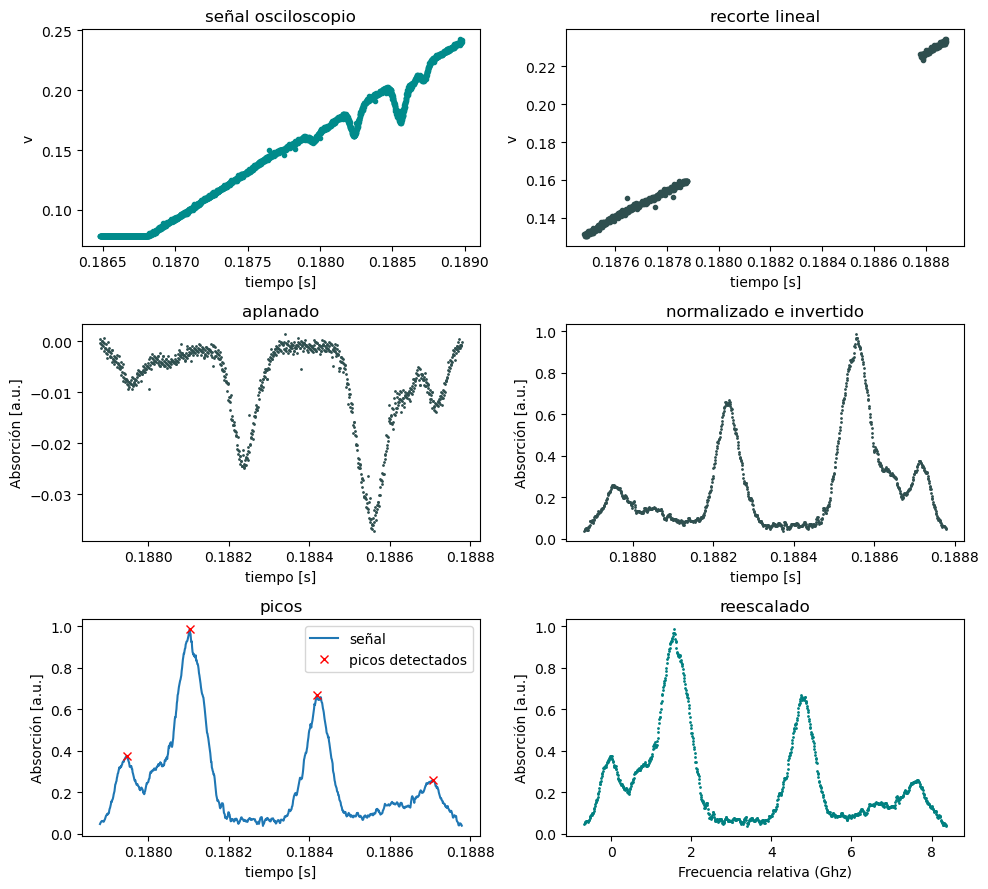

In [52]:

análisis_compacto(n=2, i=0, a = 'a', ruta='/Users/Mauri/Desktop/Labo 5/Espectroscopía láser/Med1', A =1000
                  , B = 1400, C = 2300, D = 2400, h = 0.2, dis = 100, pro = 0.05, graficar=True,  norm=True)


## prueba para comparar dos mediciones

uso ``graficar = True`` para ir ajustando los parámetros y una vez ya están bien, ocultamos los gráficos

In [57]:

análisis_compacto(n=7, i=0, a = 'b', ruta='/Users/Mauri/Downloads/Med_señal_sin_imán a T=amb', A =700
                  , B = 1000, C = 1600, D = 2000, h = 0.2, dis = 50, pro = 0.05, graficar=False, norm =True)

In [58]:
análisis_compacto(n=7, i=1, a = 'c', ruta='/Users/Mauri/Downloads/Med_señal_sin_imán a T=amb', A =100
                  , B = 400, C = 1800, D = 2000, h = 0.2, dis = 10, pro = 0.05, graficar=False, norm =True)

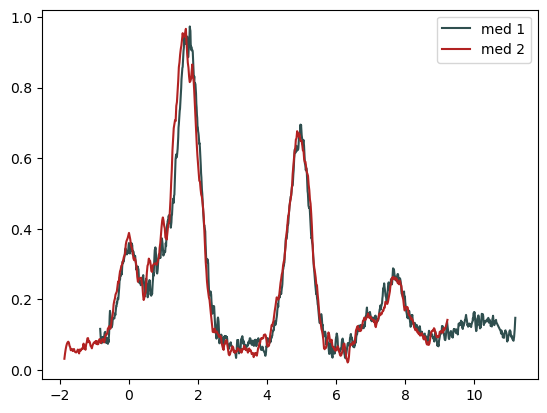

In [59]:

plt.plot(f_rel_c, espectro_suave_c, '-', color = 'darkslategray', label = 'med 1')
plt.plot(f_rel_b, espectro_suave_b, '-', color = 'firebrick', label = 'med 2')
plt.legend()
plt.show()


## para comparar a distintas temperaturas

Habiendo analizado cada uno, para graficar todas juntas

In [ ]:
# Armar lista con cada uno de los ejes x y cada uno de los ejes y

dominios = [f_rel_25, f_rel_28, f_rel_30, f_rel_32, f_rel_37, f_rel_40]
imagenes = [espectro_suave_25, espectro_suave_28, espectro_suave_30, espectro_suave_32, espectro_suave_37, espectro_suave_40]

temperaturas = [25, 28, 30, 32, 37, 40]


#para ver las amplitudes relativas entre cada medición, 
#usando las imágenes obtenidas con norm = False!
#normalizo por el espectro más grande
valor_maximo = max(np.max(arr) for arr in imagenes) #es el mayor valor de todos los arrays
imagenes = [arr / valor_maximo for arr in imagenes] # esto divide a cada array de la lista por el valor_maximo


# Usamos un colormap para generar colores automáticamente
colormap = plt.cm.plasma  # plasma, magma, viridis, inferno, etc.
num_senales = len(dominios)
colors = [colormap(i / (num_senales - 1)) for i in range(num_senales)]

# Graficamos
plt.figure(figsize=(10, 6))

for i in range(num_senales):
    plt.plot(dominios[i], imagenes[i], color=colors[i], label=f"T = {temperaturas[i]}°C")

plt.title("Espectro en función de la temperatura del Rb")
plt.xlabel("Frecuencias relativas [Ghz]")
plt.ylabel("Absorción [a.u.]")
plt.legend()
plt.grid(True, alpha = 0.6)
plt.show()


## ejemplo
(usé mediciones que no son a distintas temperaturas)

In [45]:
análisis_compacto(n=7, i=0, a = 'b', ruta='/Users/Mauri/Downloads/Med_señal_sin_imán a T=amb', A =700
                  , B = 1000, C = 1600, D = 2000, h = 0.2, dis = 50, pro = 0.05, graficar=False, norm =False)

In [46]:
análisis_compacto(n=7, i=1, a = 'c', ruta='/Users/Mauri/Downloads/Med_señal_sin_imán a T=amb', A =100
                  , B = 400, C = 1800, D = 2000, h = 0.2, dis = 10, pro = 0.05, graficar=False, norm =False)

In [47]:
análisis_compacto(n=7, i=2, a = 'd', ruta='/Users/Mauri/Downloads/Med_señal_sin_imán a T=amb', A =400
                  , B = 800, C = 1900, D = 2300, h = 0.2, dis = 10, pro = 0.05, graficar=False, norm =False)

In [48]:
análisis_compacto(n=7, i=3, a = 'e', ruta='/Users/Mauri/Downloads/Med_señal_sin_imán a T=amb', A =300
                  , B = 700, C = 1900, D = 2300, h = 0.2, dis = 10, pro = 0.05, graficar=False, norm =False)

In [49]:
análisis_compacto(n=7, i=4, a = 'f', ruta='/Users/Mauri/Downloads/Med_señal_sin_imán a T=amb', A =300
                  , B = 700, C = 1900, D = 2300, h = 0.2, dis = 10, pro = 0.05, graficar=False, norm =False)

In [50]:
análisis_compacto(n=7, i=5, a = 'g', ruta='/Users/Mauri/Downloads/Med_señal_sin_imán a T=amb', A =300
                  , B = 700, C = 1900, D = 2300, h = 0.2, dis = 10, pro = 0.05, graficar=False, norm =False)

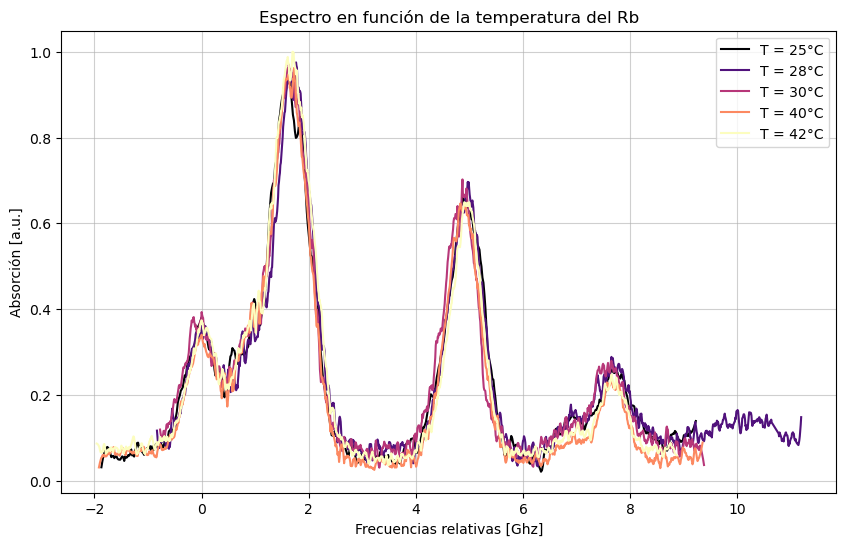

In [56]:
dominios = [f_rel_b, f_rel_c, f_rel_d, f_rel_f, f_rel_g]
imagenes = [espectro_suave_b, espectro_suave_c, espectro_suave_d, espectro_suave_f, espectro_suave_g]
#(saqué la e porque estaba un poco desfasada)

temperaturas = [25, 28, 30, 40, 42]



#para ver las amplitudes relativas entre cada medición, 
#usando las imágenes obtenidas con norm = False!
#normalizo por el espectro más grande
valor_maximo = max(np.max(arr) for arr in imagenes) #es el mayor valor de todos los arrays
imagenes = [arr / valor_maximo for arr in imagenes] # esto divide a cada array de la lista por el valor_maximo



# Usamos un colormap para generar colores automáticamente
colormap = plt.cm.magma  # plasma, magma, viridis, inferno, etc.
num_senales = len(dominios)
colors = [colormap(i / (num_senales - 1)) for i in range(num_senales)]

# Graficamos
plt.figure(figsize=(10, 6))

for i in range(num_senales):
    plt.plot(dominios[i], imagenes[i], color=colors[i], label=f"T = {temperaturas[i]}°C")

plt.title("Espectro en función de la temperatura del Rb")
plt.xlabel("Frecuencias relativas [Ghz]")
plt.ylabel("Absorción [a.u.]")
plt.legend()
plt.grid(True, alpha = 0.6)
plt.show()

aclaración

Esta comparación es medio cualitativa ya que, las alturas de los picos de los espectros dependen directamente de las lineales por las cuales ajustamos a la señal original, y mucho más de que al calcular espectro_pos, estoy subiendo la señal (corriéndola hacia arriba) por el número más bajo que medimos, que depende del corte que se hizo en cada caso, y del ruido de cada medición. Peero si hacemos todas las mediciones seguidas y sin tocar nada, la comparación es muy acertada.
